In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle
import re
from datetime import datetime
import gcsfs 
import requests

In [2]:
# From https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0160492/

# Download path
ldeo_url  = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0160492/LDEO_Database_V2019.csv'
# GCS path to save the data
save_path = 'gs://leap-persistent/ckg-2dxsu/Taylor_data/databases'
# Edit the file name if needed.
gcs_path = f'{save_path}/raw/LDEO_Database_V2019.csv'

# If you want to change the outcome .nc save path or file name, search for "zarr_gcs_path" later in this notebook


In [3]:
fs = gcsfs.GCSFileSystem()

if fs.exists(gcs_path):
    print(f"File already exists at {gcs_path}. Skipping download.")
else:
    # download and save to GCS
    response = requests.get(ldeo_url, stream=True)
    if response.status_code == 200:
        with fs.open(gcs_path, 'wb') as gcs_file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:  # filter out keep-alive new chunks
                    gcs_file.write(chunk)
        print(f"Succesfully downloaded and saved to {gcs_path}")
    else:
        print(f"Error! Could not download: {response.status_code}")

Succesfully downloaded and saved to gs://leap-persistent/ckg-2dxsu/Taylor_data/databases/raw/LDEO_Database_V2019.csv


In [23]:
fs = gcsfs.GCSFileSystem()
fs.ls('gs://leap-persistent/ckg-2dxsu/Taylor_data/databases/raw')

['leap-persistent/ckg-2dxsu/Taylor_data/databases/raw/GLODAPv2.2023_Merged_Master_File.csv.zip',
 'leap-persistent/ckg-2dxsu/Taylor_data/databases/raw/HOT_surface_CO2.txt',
 'leap-persistent/ckg-2dxsu/Taylor_data/databases/raw/LDEO_Database_V2019.csv',
 'leap-persistent/ckg-2dxsu/Taylor_data/databases/raw/bats_bottle.txt']

In [5]:
# load data from GCS
with fs.open(gcs_path) as f:
    df = pd.read_csv(f)

/tmp/ipykernel_1501/2615056617.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


In [6]:
df.head()

,FILENAME,STN,LAT,LON,MONTH/DAY/YEAR,JDATE,VCO2_SW,TEMP_PCO2,TEMP,SAL,PCO2_SST,PCO2_SSTPA,PCO2_TEQ,EQ_PBARO,SHIPPBARO
0,0002,1,-58.823,-60.967,4/9/2000,100.24912,364.84,3.30,0.00,33.50,309.35,31.345,356.7,998.3,998.3
1,0002,2,-58.829,-60.962,4/9/2000,100.25045,364.21,3.25,2.56,33.50,345.68,35.026,356.1,998.2,998.2
2,0002,3,-58.834,-60.956,4/9/2000,100.25173,364.61,3.27,2.56,33.47,345.77,35.035,356.5,998.3,998.3
3,0002,4,-58.839,-60.950,4/9/2000,100.25302,365.01,3.33,2.63,33.45,346.21,35.080,356.8,998.0,998.0
4,0002,5,-58.844,-60.944,4/9/2000,100.25430,365.32,3.33,2.63,33.44,346.50,35.109,357.1,998.2,998.2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14177826 entries, 0 to 14177825
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   FILENAME        object 
 1   STN             int64  
 2   LAT             float64
 3   LON             float64
 4   MONTH/DAY/YEAR  object 
 5   JDATE           float64
 6   VCO2_SW         float64
 7   TEMP_PCO2       float64
 8   TEMP            float64
 9   SAL             float64
 10  PCO2_SST        float64
 11  PCO2_SSTPA      float64
 12  PCO2_TEQ        float64
 13  EQ_PBARO        float64
 14  SHIPPBARO       float64
dtypes: float64(12), int64(1), object(2)
memory usage: 1.6+ GB


In [8]:
# use PCO2_SST for now!!!
df_ed = df[['LAT', 'LON', 'MONTH/DAY/YEAR', 'TEMP','PCO2_SST']]
df_ed.head()

,LAT,LON,MONTH/DAY/YEAR,TEMP,PCO2_SST
0,-58.823,-60.967,4/9/2000,0.00,309.35
1,-58.829,-60.962,4/9/2000,2.56,345.68
2,-58.834,-60.956,4/9/2000,2.56,345.77
3,-58.839,-60.950,4/9/2000,2.63,346.21
4,-58.844,-60.944,4/9/2000,2.63,346.50


In [9]:
### Convert from -180 / 180 to 0/360 longitude
def f(row):
    if row['LON'] < 0:
        val = row['LON'] + 360
    else:
        val = row['LON']
    return val

### Apply function to dataframe 
df_ed['LON360'] = df_ed.apply(f, axis=1)

df_ed.head()

/tmp/ipykernel_1501/1063574601.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ed['LON360'] = df_ed.apply(f, axis=1)


,LAT,LON,MONTH/DAY/YEAR,TEMP,PCO2_SST,LON360
0,-58.823,-60.967,4/9/2000,0.00,309.35,299.033
1,-58.829,-60.962,4/9/2000,2.56,345.68,299.038
2,-58.834,-60.956,4/9/2000,2.56,345.77,299.044
3,-58.839,-60.950,4/9/2000,2.63,346.21,299.050
4,-58.844,-60.944,4/9/2000,2.63,346.50,299.056


In [10]:
# Convert data types
columns_to_convert = ['TEMP','PCO2_SST']
for column in columns_to_convert:
    df_ed[column] = pd.to_numeric(df_ed[column], errors='coerce')

# Change date format
df_ed['DATE'] = pd.to_datetime(df_ed['MONTH/DAY/YEAR']).dt.strftime('%Y-%m-%d')

### Set index to dates
df_ed_sub = df_ed.loc[:, ['DATE', 'LAT', 'LON360', 'PCO2_SST']].rename(columns={'LAT':'lat', 'LON360':'lon', 'PCO2_SST':'spco2', 'DATE':'time'}).set_index(['time'])

df_ed_sub.head()

/tmp/ipykernel_1501/3910596934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ed[column] = pd.to_numeric(df_ed[column], errors='coerce')
/tmp/ipykernel_1501/3910596934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ed['DATE'] = pd.to_datetime(df_ed['MONTH/DAY/YEAR']).dt.strftime('%Y-%m-%d')


,lat,lon,spco2
time,,,
2000-04-09,-58.823,299.033,309.35
2000-04-09,-58.829,299.038,345.68
2000-04-09,-58.834,299.044,345.77
2000-04-09,-58.839,299.050,346.21
2000-04-09,-58.844,299.056,346.50


In [11]:
df_ed_sorted = df_ed.sort_values(by='DATE')
df_ed_sorted.head()

,LAT,LON,MONTH/DAY/YEAR,TEMP,PCO2_SST,LON360,DATE
4040619,29.767,-120.250,10/22/1957,20.3,325.91,239.750,1957-10-22
4040620,29.133,-120.750,10/23/1957,19.8,324.92,239.250,1957-10-23
4040621,28.983,-120.883,10/23/1957,19.8,326.80,239.117,1957-10-23
4040622,28.733,-121.150,10/23/1957,20.3,328.38,238.850,1957-10-23
4040623,28.617,-121.283,10/23/1957,20.4,330.54,238.717,1957-10-23


In [12]:
min_date_str = df_ed_sub.index.min()
max_date_str = df_ed_sub.index.max()
date_range = [min_date_str,max_date_str]
print(f'Date range is:{date_range[0]} to {date_range[1]}.')

# Define spatial range
lon = np.arange(0.5, 360, 1)
lat = np.arange(-89.5, 90, 1)
time = pd.date_range(start=f'{date_range[0]}-01T00:00:00.000000000',
                     end=f'{date_range[1]}-01T00:00:00.000000000',
                     freq='MS') + np.timedelta64(14, 'D')

# Create DataArray
xda = xr.DataArray(np.zeros((len(time), len(lat), len(lon))),
                   dims=['time', 'lat', 'lon'],
                   coords=[time, lat, lon])

# Convert data into series
ds_gd = pd.DataFrame({
    'time': df_ed_sub.index,
    'lon': df_ed_sub.lon.values,
    'lat': df_ed_sub.lat.values,
    'spco2': df_ed_sub.spco2.values
})

Date range is:1957-10-22 to 2019-12-23.


/tmp/ipykernel_1501/330321989.py:9: FutureWarning: Parsed string "1957-10-22-01T00:00:00.000000000" included an un-recognized timezone "T". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  time = pd.date_range(start=f'{date_range[0]}-01T00:00:00.000000000',
/tmp/ipykernel_1501/330321989.py:9: FutureWarning: Parsed string "2019-12-23-01T00:00:00.000000000" included an un-recognized timezone "T". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  time = pd.date_range(start=f'{date_range[0]}-01T00:00:00.000000000',


In [13]:
ds_gd.head()

,time,lon,lat,spco2
0,2000-04-09,299.033,-58.823,309.35
1,2000-04-09,299.038,-58.829,345.68
2,2000-04-09,299.044,-58.834,345.77
3,2000-04-09,299.050,-58.839,346.21
4,2000-04-09,299.056,-58.844,346.50


In [14]:
ds_gd['time'] = pd.to_datetime(ds_gd['time'])
# ds_gd_sorted = ds_gd.sort_values(by='time')
ds_gd['time'].dtype

dtype('<M8[ns]')

In [15]:
ds_gd.time.min()

Timestamp('1957-10-22 00:00:00')

In [16]:
# Check if coordinates are present and correctly formatted
for key in ['time', 'lat', 'lon']:
     assert key in xda.dims, '`{}` is not in the input DataArray'.format(key)
assert all(np.diff(xda.time.values) > np.timedelta64(0, 'D')), 'time is not strictly increasing'
assert all(np.diff(xda.lat.values) > 0), 'latitude is not strictly increasing'
assert all(np.diff(xda.lon.values) > 0), 'longitude is not strictly increasing'
assert np.issubdtype(ds_gd['time'].dtype, np.datetime64), 'time must be in datetime64 format'

# Create bins for time, latitude, and longitude
def make_bins(dim):
    delta = np.diff(dim) / 2
    bins = np.r_[dim[0] - delta[0], dim[1:] - delta, dim[-1] + delta[-1]]
    return bins

tbins = make_bins(xda.time.values)
ybins = make_bins(xda.lat.values)
xbins = make_bins(xda.lon.values)

# Bin the data and get indices
tidx = pd.cut(ds_gd['time'], tbins, labels=np.arange(len(xda.time)))
yidx = pd.cut(ds_gd['lat'], ybins, labels=np.arange(len(xda.lat)))
xidx = pd.cut(ds_gd['lon'], xbins, labels=np.arange(len(xda.lon)))

print("Number of NaNs in bin indices:")
print(f"tidx: {tidx.isna().sum()}, yidx: {yidx.isna().sum()}, xidx: {xidx.isna().sum()}")

# Group by bins and calculate mean and standard deviation
df2 = (pd.DataFrame({'spco2': ds_gd['spco2'], 'tidx': tidx, 'yidx': yidx, 'xidx': xidx})
      .dropna()  # Drop rows where binning failed
      .groupby(['tidx', 'yidx', 'xidx'])
      .agg(['mean', 'std'])
      .reset_index()
      .rename(columns={'tidx': 'it', 'yidx': 'iy', 'xidx': 'ix'}))
'''
df2 = (pd.Series(ds_gd.spco2)
          .groupby([tidx, yidx, xidx])
          .agg(['mean', 'std'])
          .reset_index()
          .rename(columns={'level_0': 'it',
                           'level_1': 'iy',
                           'level_2': 'ix'}))
'''
# df2 = df2.dropna()

Number of NaNs in bin indices:
tidx: 103, yidx: 0, xidx: 2951


/tmp/ipykernel_1501/3074895837.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['tidx', 'yidx', 'xidx'])


"\ndf2 = (pd.Series(ds_gd.spco2)\n          .groupby([tidx, yidx, xidx])\n          .agg(['mean', 'std'])\n          .reset_index()\n          .rename(columns={'level_0': 'it',\n                           'level_1': 'iy',\n                           'level_2': 'ix'}))\n"

In [17]:
df2.head()

it iy ix spco2    
            mean std
0  0  0  0   NaN NaN
1  0  0  1   NaN NaN
2  0  0  2   NaN NaN
3  0  0  3   NaN NaN
4  0  0  4   NaN NaN

In [18]:
# Convert indices to integers
it, iy, ix = df2[['it', 'iy', 'ix']].values.T.astype(int)

# Create DataArray to store the results
xda_mean = xda.copy() * np.nan
xda_std = xda.copy() * np.nan
xda_mean.name = 'spco2_mean'
xda_std.name = 'spco2_std'

# Place the binned mean and standard deviation into the DataArray
xda_mean.values[it, iy, ix] = df2[('spco2', 'mean')]
xda_std.values[it, iy, ix] = df2[('spco2', 'std')]

# Merge into a single Dataset
out = xr.merge([xda_mean, xda_std])

# Rename variables
ldeo_out = out.rename({'spco2_mean': 'spco2_mean', 'spco2_std': 'spco2_std'})

In [19]:
# Save to GCS as zarr
zarr_gcs_path = f'{save_path}/processed/LDEOv2019_spco2.zarr'

ldeo_out.to_zarr( zarr_gcs_path, mode='w')

# Check if saved sucessfully
if fs.exists(zarr_gcs_path):
    print(f"Successfully saved to {zarr_gcs_path}")
else:
    print(f"Failed to save to {zarr_gcs_path}")

Successfully saved to gs://leap-persistent/ckg-2dxsu/Taylor_data/databases/processed/LDEOv2019_spco2.zarr


In [20]:
fs.ls(save_path + '/processed')

['leap-persistent/ckg-2dxsu/Taylor_data/databases/processed/HOT_spco2_202312.zarr',
 'leap-persistent/ckg-2dxsu/Taylor_data/databases/processed/LDEOv2019_spco2.zarr',
 'leap-persistent/ckg-2dxsu/Taylor_data/databases/processed/bats_spco2_1988-10-2023-06.zarr']

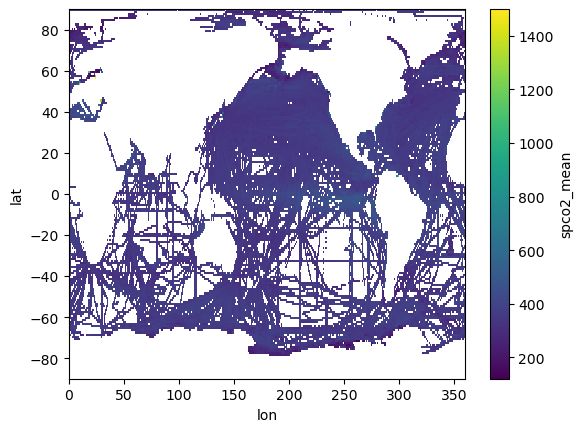

In [21]:
ldeo_out.spco2_mean.mean('time').plot()

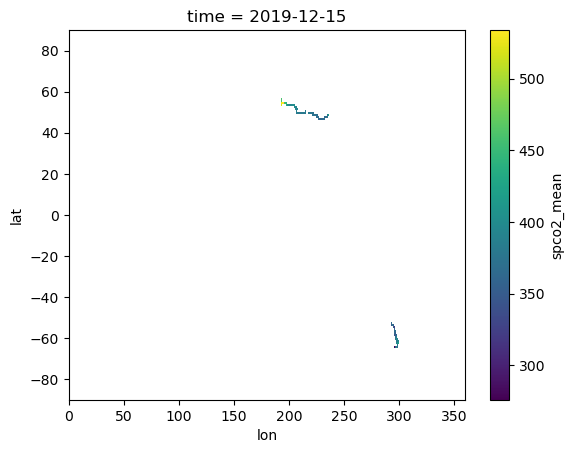

In [22]:
ldeo_out.spco2_mean.sel(time = '2021-05',method='nearest').plot()

In [ ]:
# If you want to delete file from the GCS path, run the following code
'''
delete_path = 'gs://leap-persistent/ckg-2dxsu/Taylor_data/GLODAPv2.2023_Merged_Master_File.csv'

fs = gcsfs.GCSFileSystem()

if fs.exists(delete_path):
    fs.rm(delete_path, recursive=True)
    print(f"The file {delete_path} has been deleted")
else:
    print(f"The file {delete_path} does not exist")
'''